In [1]:
import os
from pathlib import Path
import sys
import numpy as np
import scvelo as scv

Global seed set to 0


In [2]:
notebook_dir = os.getcwd()
notebook_dir

'/home/sergio/Jnotebooks/SALMON/github_repo/SALMON/notebooks/pipeline_control'

In [3]:
Path(notebook_dir).parents[2]

PosixPath('/home/sergio/Jnotebooks/SALMON/github_repo')

In [4]:
os.chdir(Path(notebook_dir).parents[2])

In [5]:
stvelo_path = os.path.join(os.getcwd(),'SALMON','stvelo')

In [6]:
stvelo_path

'/home/sergio/Jnotebooks/SALMON/github_repo/SALMON/stvelo'

In [7]:
import sys  
sys.path.insert(1,stvelo_path)
from pipelines.simulate_3ode import *
from pipelines.metrics import *
from pipelines.preprocessing import Preprocessing
from pipelines.compute_velocity import Velocities
from pipelines.spatial_artifacts import *
from simulating.simulate_spatial_artifacts import *
from pipelines.utils import *

# Input 

In [8]:
n_cells=800
n_genes=200
t_max=20 #### maybe could be fix?
mu = np.array([3, 1.8, 0.8, 0.5])

R = np.array([[.16, .128, .08, .032],
              [.128, .16 , .08, .032],
              [.08, .08, .16 , .08],
              [.032 ,.032 , .08 , .16]])

C = np.array([0.4, 0.4, 0.4, 0.4])[:, None]

############## CONFIG PREPROCESSING #####################
config_preprocessing = {'preprocess_params': { 'min_counts': 200, 'min_cells': 5, 'n_neighbors': 23, 'n_pcs': 0, 'min_dist': 1},
'functions_to_apply': {'filter_cells': True,  'filter_genes': True,   'normalize_total': True,  'log1p': True,
'pca': True,   'neighbors': True,   'umap': True,   'leiden': True,   'moments': True}}

############## CONFIG VELOCITY #####################
# config_velocity = { 'velocity_types': ['dynamical','deterministic','stochastic','velovi']}
config_velocity = { 'velocity_types': ['deterministic']}


# Simulation

In [9]:
cov = C * R
cov=np.log(cov)
alpha, beta , nu, gamma = np.exp(np.random.multivariate_normal(mu, cov, size = n_genes).T)
s = switch_times(20,300)

In [49]:
adata_dict = simulation_3ode(n_obs=n_cells,alpha=alpha, beta= beta, nu=nu, gamma=gamma, t_max=t_max, switches=s/20,n_vars=n_genes)

In [50]:
import numpy as np
import anndata as ad

def compute_true_rna_velocity(adata):
    # Extract spliced and unspliced counts from adata layers
    spliced = adata.layers['spliced']
    unspliced = adata.layers['unspliced']
    
    # Extract true alpha, beta, and gamma from adata.obs
    alpha = adata.var['true_alpha'].values
    beta = adata.var['true_beta'].values
    gamma = adata.var['true_gamma'].values
    
    # Initialize a matrix to store RNA velocity (same shape as spliced/unspliced)
    velocity = np.zeros_like(spliced)
    # Calculate RNA velocity for each cell (row) and each gene (column)
    for i in range(spliced.shape[1]):  # iterate over cells
        velocity[:, i] = beta[i] * unspliced[:, i] - gamma[i] * spliced[:, i]
    # Store the calculated velocity in a new layer of the adata object
    adata.layers['true_velocity'] = velocity
    
    return adata

def get_true_rna_velocity(adata_dict):
    for k,adata in adata_dict.items():
        compute_true_rna_velocity(adata)
    return adata_dict

In [51]:
adata_dict=get_true_rna_velocity(adata_dict)

# Spatial artifacts would go here

In [11]:
adata_dict=add_2d_missegmentation_artifacts(adata_dict=adata_dict, cell_radius=10, section_thickness=20, mean_cytoplasmic=0.4, proportion_of_cells_cut=0.01)

Simulating missegmentation artifacts: 100%|█████████████████████████████████████████| 800/800 [00:00<00:00, 1673.33it/s]


# Preprocessing

In [53]:
for key, adata in adata_dict.items():
    print(f'{key} is being preprocessed.')
    preprocessor = Preprocessing(adata,config_preprocessing)
    adata_dict[key] = preprocessor.preprocess_data()

adata_s_u is being preprocessed.


2024-09-26 17:11:03.925838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
adata_n_c is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Keep common cells

In [54]:
adata_dict=keep_common_cells(adata_dict)

# Velocities

In [55]:
velocity_computer = Velocities(adata_dict,config_velocity)
adata_dict_velocity = velocity_computer.compute_velocities()

Using device: cpu
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/797 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/797 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Plotting 

In [56]:
from pipelines.plot import Plotter
import matplotlib.pyplot as plt

In [57]:
saving_plots_path = os.path.join(os.getcwd(),'outputs','plots')
saving_plots_path

'/home/sergio/Jnotebooks/SALMON/github_repo/outputs/plots'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
An error occurred while generating velocity_embedding_stream for clusters: color key is invalid! pass valid observation annotation or a gene name
An error occurred while generating velocity_embedding_grid for clusters: color key is invalid! pass valid observation annotation or a gene name
An error occurred while generating velocity_embedding for clusters: color key is invalid! pass valid observation annotation or a gene name
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f5faa1f1550> (for post_execute):


KeyboardInterrupt: 

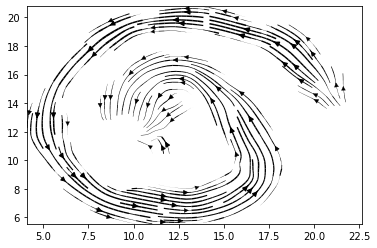

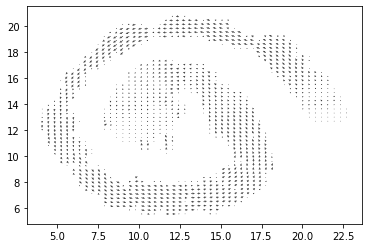

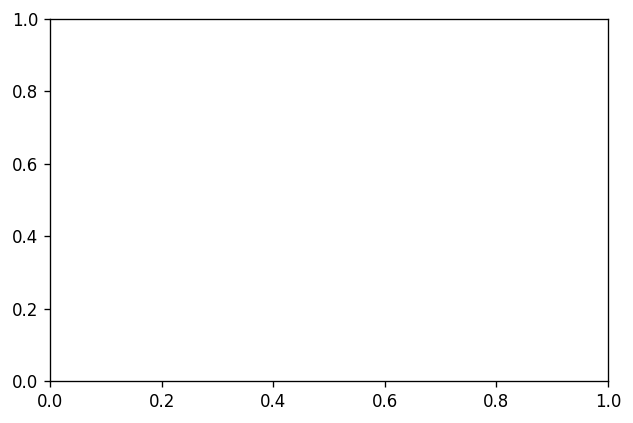

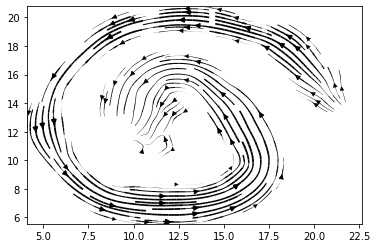

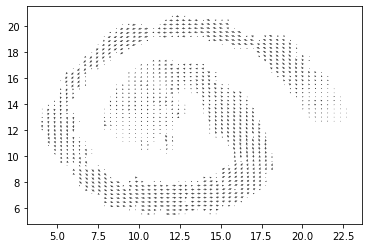

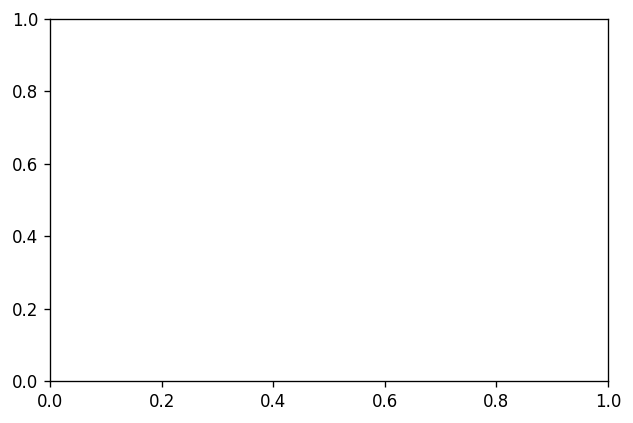

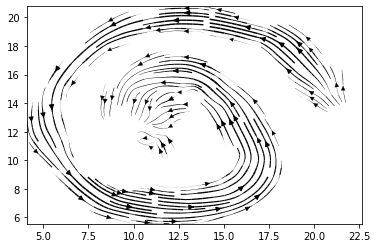

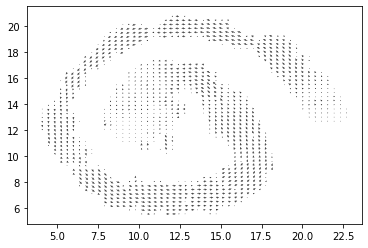

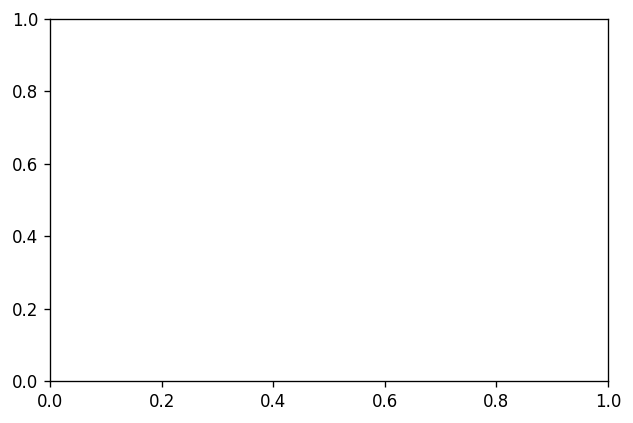

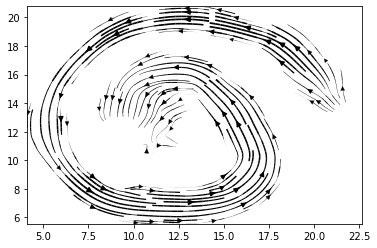

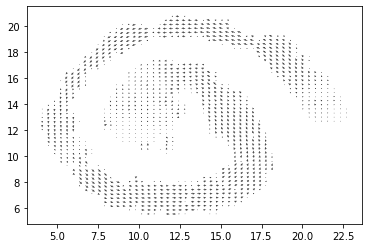

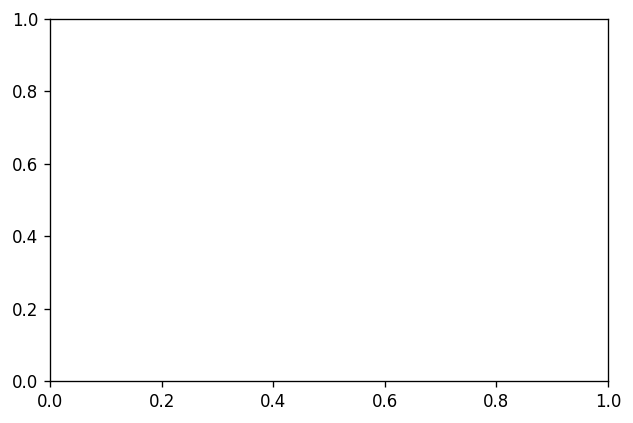

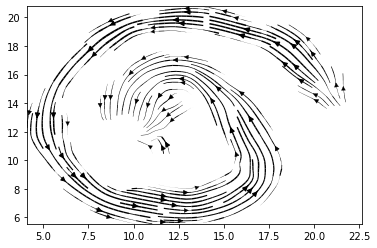

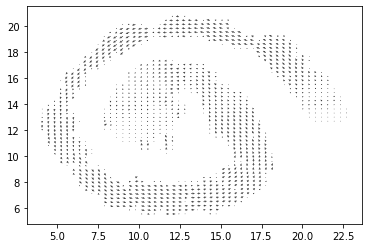

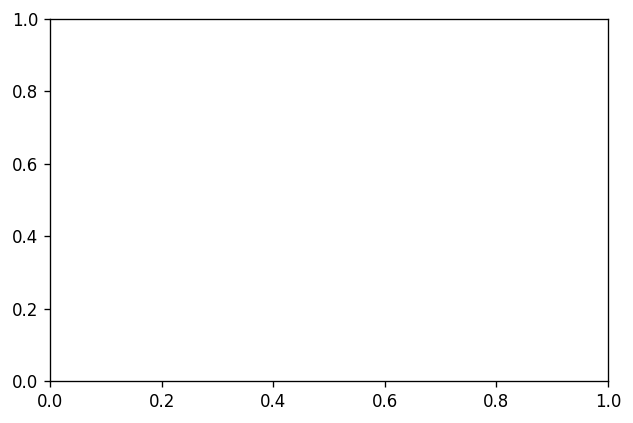

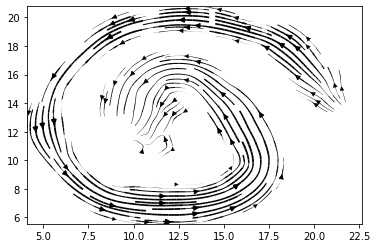

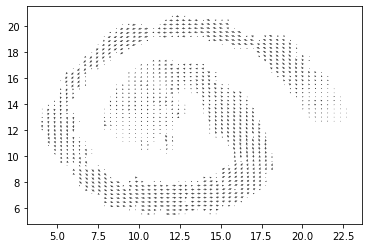

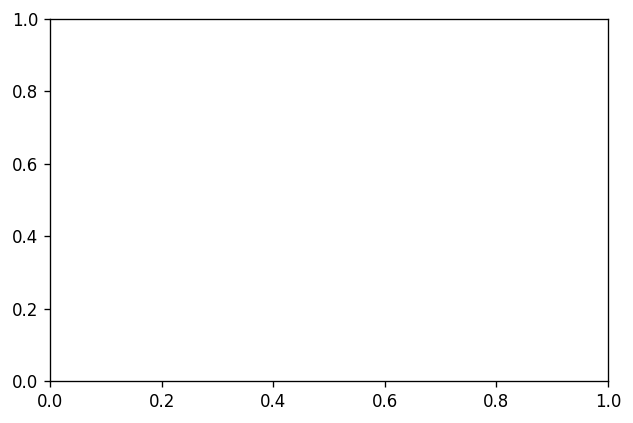

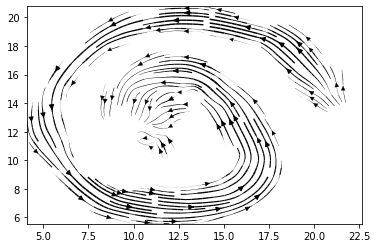

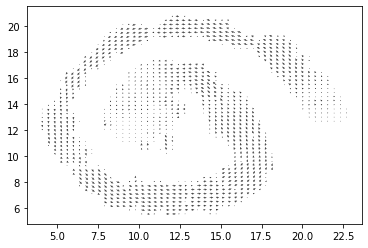

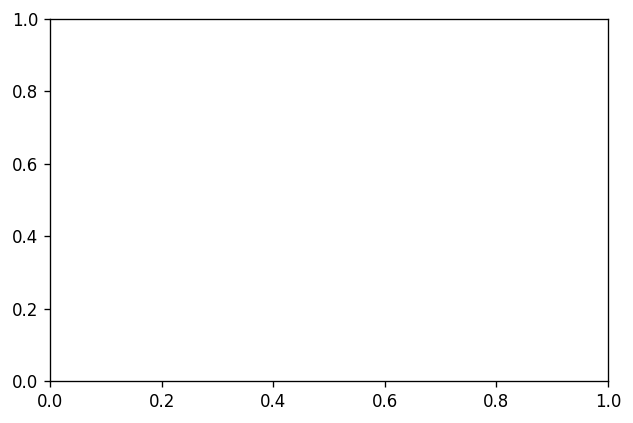

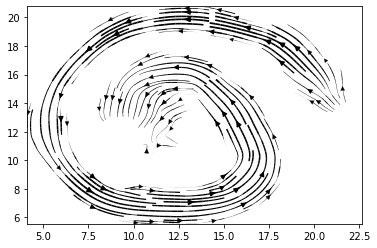

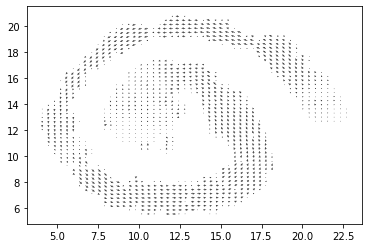

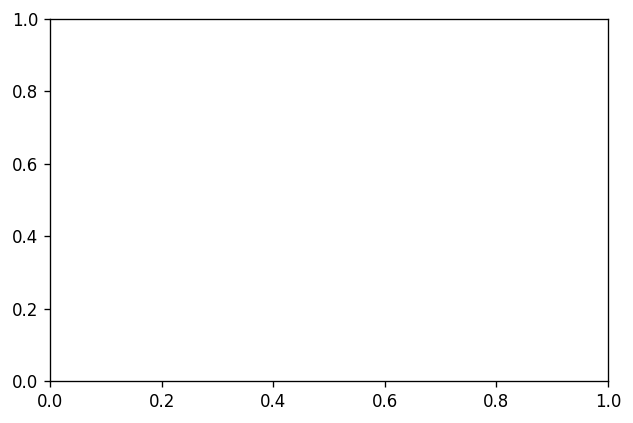

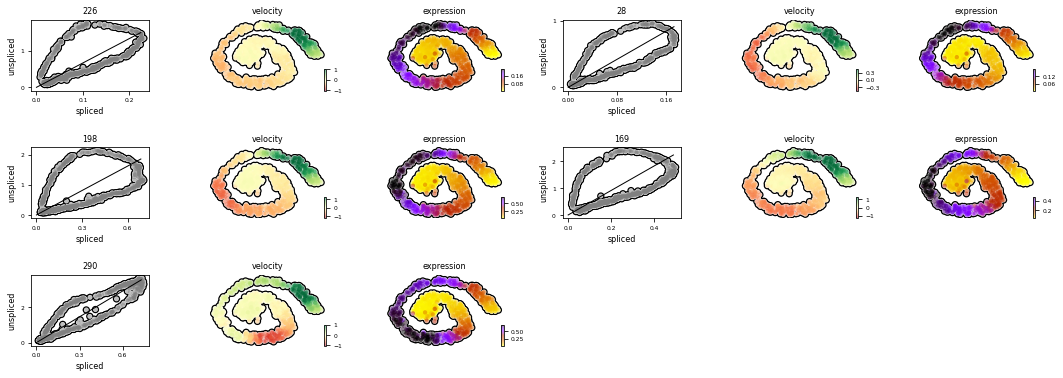

In [18]:
config = {
    'colorsets': ['leiden'],
    'velocity_embedding_stream': True,
    'velocity_embedding_grid': True,
    'velocity_embedding': True,
    'rank_velocity_genes': True,
    'velocity_confidence': True,
    'velocity_length': True
}

saving_plots_path = os.path.join(os.getcwd(),'outputs','plots')

# Create an instance of the class
plotter = Plotter(adata_dict=adata_dict_velocity, config=config, saving_path=saving_plots_path,saving_format='png')

# Generate the plots
plotter.generate_plots(save=True)

# This will be implemented into a function (basic plotting)

In [18]:
ad = adata_dict_velocity['adata_n_c_deterministic']

In [19]:
saving_plots_path

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\outputs\\plots'

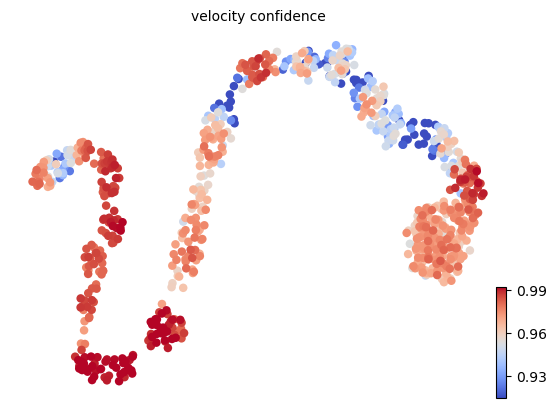

In [20]:
scv.pl.scatter(ad, c='velocity_confidence', cmap='coolwarm', perc=[5, 95],show=False)
plt.savefig(os.path.join(saving_plots_path,'umap_confidence.png'))


In [ ]:
import os 
if not os.path.exists(saving_plots_path):
    os.mkdir(saving_plots_path)
for d in adata_dict_velocity.keys():
    adata=adata_dict_velocity[d]
    saving_adata_path=os.path.join(saving_plots_path,d)
    if not os.path.exists(os.path.join(saving_plots_path,d)):
        os.mkdir(os.path.join(saving_plots_path,d))
    sets=['leiden']
    for colorset in sets:
        try:
            scv.pl.velocity_embedding_stream(adata, basis='umap',color=colorset,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_stream.svg'.format(colorset)))
            scv.pl.velocity_embedding_grid(adata, basis='umap',color=colorset,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_grid.svg'.format(colorset)))
            scv.pl.velocity_embedding(adata, arrow_length=3,color=colorset, arrow_size=2, dpi=120,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_embedding.svg'.format(colorset)))
        except:
            pass
    ####
    scv.tl.rank_velocity_genes(adata, groupby='leiden', min_corr=.3)
    df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
    for col in df.columns:
        scv.pl.scatter(adata, df[col][:5], ylabel=col,color='leiden',show=False)
        plt.savefig(os.path.join(saving_adata_path,'scatterplot_velo_{}.svg'.format(col)))
        scv.pl.velocity(adata, df[col][:5], ncols=2, add_outline=True,show=False)
        plt.savefig(os.path.join(saving_adata_path,'velocity_plots_{}.svg'.format(col)))
    scv.tl.velocity_confidence(adata)
    scv.pl.scatter(adata, c='velocity_confidence', cmap='coolwarm', perc=[5, 95],show=False)
    plt.savefig(os.path.join(saving_adata_path,'umap_confidence.svg'))
    scv.pl.scatter(adata, c='velocity_length', cmap='coolwarm', perc=[5, 95],show=False)
    plt.savefig(os.path.join(saving_adata_path,'umap_velocity_length.svg'))

# Save results (if needed)

In [16]:
saving_adata_path=os.path.join(saving_plots_path,'adata')
if not os.path.exists(saving_adata_path):
        os.mkdir(saving_adata_path)

NameError: name 'saving_plots_path' is not defined

In [20]:
for d in adata_dict_velocity.keys():
    print(d)
    adata_dict_velocity[d].write(os.path.join(saving_adata_path,d+'.h5ad'))

adata_s_u_deterministic
adata_n_c_deterministic
adata_s_u_2dseg_deterministic
adata_n_c_2dseg_deterministic


# Cosine similiarity against ground truth

In [58]:
adata_dict

{'adata_s_u': View of AnnData object with n_obs × n_vars = 797 × 200
     obs: 'true_t', 'n_counts', 'leiden'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'unspliced', 'spliced', 'true_velocity', 'Ms', 'Mu'
     obsp: 'distances', 'connectivities',
 'adata_n_c': View of AnnData object with n_obs × n_vars = 797 × 200
     obs: 'true_t', 'n_counts', 'leiden'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'unspliced', 'spliced', 'true_velocity', 'Ms', 'Mu'
     obsp: 'distances', 'connectivities'}

In [64]:
adata

AnnData object with n_obs × n_vars = 797 × 200
    obs: 'true_t', 'n_counts', 'leiden'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'true_velocity', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [73]:
def velocity_mse_against_true_velocity(adata_dict,mode='by_gene'):

    d1=list(adata_dict.keys())[0]
    # Initialize the MSE matrix with appropriate indexing
    if mode == 'by_gene':
        mse_mat = pd.DataFrame(index=adata_dict.keys(), columns=adata_dict[d1].var.index)
    if mode == 'by_cell':
        mse_mat = pd.DataFrame(index=adata_dict.keys(), columns=adata_dict[d1].obs.index)

    # Compute MSE for each dataset in adata_dict
    for d1 in adata_dict.keys():
        velo1 = adata_dict[d1].to_df('true_velocity')  # Extract velocity data from the reference dataset
        velo2 = adata_dict[d1].to_df('velocity')  # Extract velocity data from the current dataset
        
        import numpy as np  # Import numpy for MSE computation
        
        # Compute MSE by cell (across genes)
        if mode == 'by_cell':
            mse_vals = [np.nanmean((velo1.iloc[e, :] - velo2.iloc[e, :]) ** 2) for e in range(velo1.shape[0])]
            adata_dict[d1].obs['mse_vs_true_velocity']=mse_vals
        # Compute MSE by gene (across cells)
        if mode == 'by_gene':
            mse_vals = [np.nanmean((velo1.iloc[:, e] - velo2.iloc[:, e]) ** 2) for e in range(velo1.shape[1])]
            adata_dict[d1].var['mse_vs_true_velocity']=mse_vals
        
        mse_mat.loc[d1, :] = mse_vals  # Store computed MSE in the matrix
    
    return adata_dict,mse_mat.astype(float)

In [74]:
adata_dict_velocity,mse=velocity_mse_against_true_velocity(adata_dict_velocity,mode='by_cell')
adata_dict_velocity,mse=velocity_mse_against_true_velocity(adata_dict_velocity,mode='by_gene')

# Performance metrics (this should also be a function, tbd)

In [17]:
adata_dict=adata_dict_velocity

In [18]:
# confidence 
for d in adata_dict.keys():
    print(d)
    adata_dict[d]=compute_confidence(adata_dict[d])
    
#velocity correlations (by gene or by cell)
velo_corr_bygene=velocity_mean_correlation(adata_dict,mode='by_gene')
velo_corr_bycell=velocity_mean_correlation(adata_dict,mode='by_cell')

# velocity corr against a reference 
velocity_correlation_by_gene=velocity_corr_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_gene')
velocity_correlation_by_cell=velocity_corr_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_cell')

#velo mse 
velo_mse_bygene=velocity_mean_mse(adata_dict,mode='by_gene')
velo_mse_bycell=velocity_mean_mse(adata_dict,mode='by_cell')

# velo mse against a reference 
velocity_mse_by_gene=velocity_mse_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_gene')
velocity_mse_by_cell=velocity_mse_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_cell')

adata_s_u_deterministic
computing velocity graph (using 2/32 cores)


  0%|          | 0/797 [00:00<?, ?cells/s]

Global seed set to 0
Global seed set to 0


    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
adata_n_c_deterministic
computing velocity graph (using 2/32 cores)


  0%|          | 0/797 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
adata_s_u_2dseg_deterministic
computing velocity graph (using 2/32 cores)


  0%|          | 0/797 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
adata_n_c_2dseg_deterministic
computing velocity graph (using 2/32 cores)


  0%|          | 0/797 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [26]:
adata_dict['adata_s_u_deterministic']

AnnData object with n_obs × n_vars = 797 × 200
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'Velocity confidence'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'

In [29]:
# velocity sign
sign_accuracies=get_sign_accuracy(adata_dict)


adata_s_u_dynamical


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 4546.68it/s]


adata_s_u_deterministic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5541.55it/s]


adata_n_c_dynamical


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 4796.88it/s]


adata_n_c_deterministic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5702.23it/s]


adata_s_u_2dseg_dynamical


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 4834.97it/s]


adata_s_u_2dseg_deterministic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5581.36it/s]


adata_n_c_2dseg_dynamical


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 4760.61it/s]


adata_n_c_2dseg_deterministic


100%|███████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 5667.02it/s]


# Plotting metrics

<Axes: xlabel='Velocity confidence', ylabel='velo_type'>

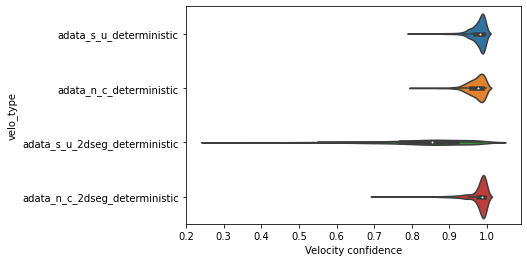

In [19]:
# confidence
import seaborn as sns
confidences=get_confidences(adata_dict)
sns.violinplot(data=confidences,x='Velocity confidence',y='velo_type')

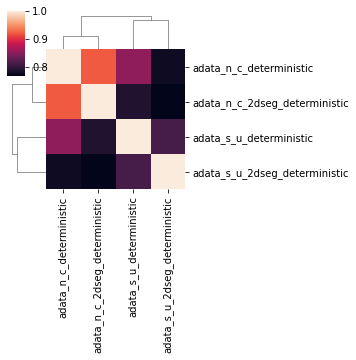

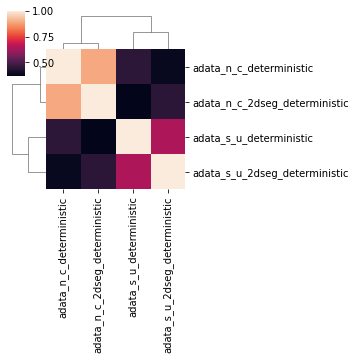

In [20]:
# velocity correlations (by gene or by cell)
sns.clustermap(velo_corr_bygene.astype(float),figsize=(5,5))
sns.clustermap(velo_corr_bycell.astype(float),figsize=(5,5))

Text(0.5, 0, 'Correlation against reference')

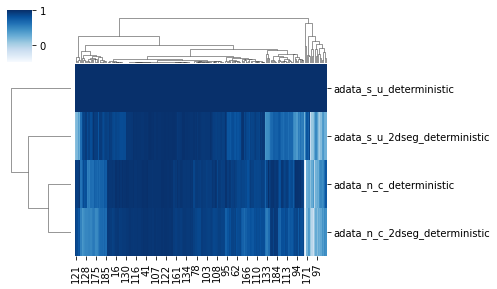

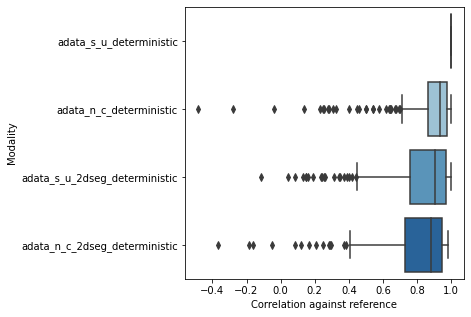

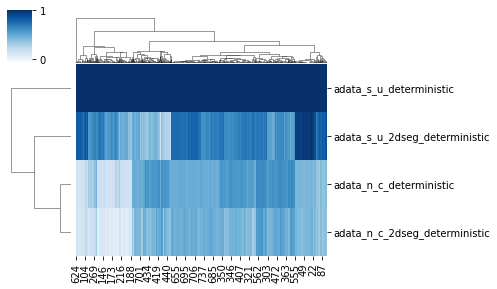

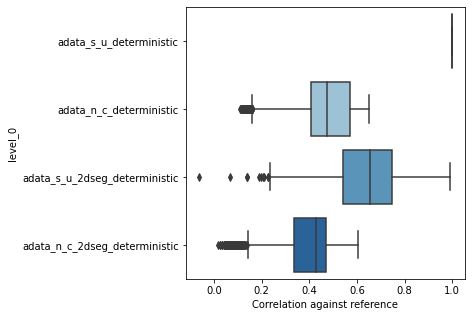

In [21]:
# velocity corr against a reference 
import matplotlib.pyplot as plt
sns.clustermap(velocity_correlation_by_gene.fillna(0),figsize=(7,4),cmap='Blues')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_correlation_by_gene.stack().reset_index(),y='level_0',x=0,palette='Blues')
plt.xlabel('Correlation against reference')
plt.ylabel('Modality')

# same, but by cell
import matplotlib.pyplot as plt
sns.clustermap(velocity_correlation_by_cell.fillna(0),figsize=(7,4),cmap='Blues')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_correlation_by_cell.stack().reset_index(),y='level_0',x=0,palette='Blues')
plt.xlabel('Correlation against reference')


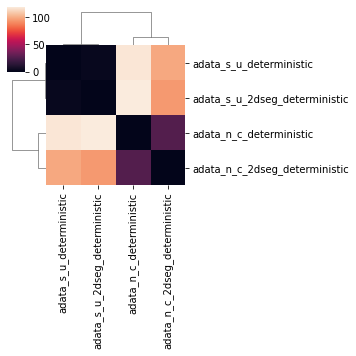

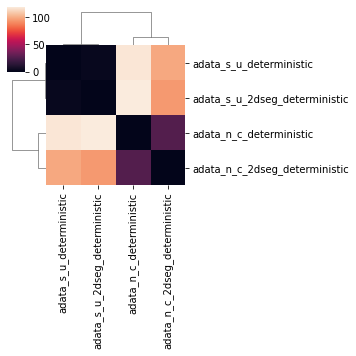

In [22]:
# velo mse
sns.clustermap(velo_mse_bygene.astype(float),figsize=(5,5))
sns.clustermap(velo_mse_bycell.astype(float),figsize=(5,5))

Text(0, 0.5, 'Modality')

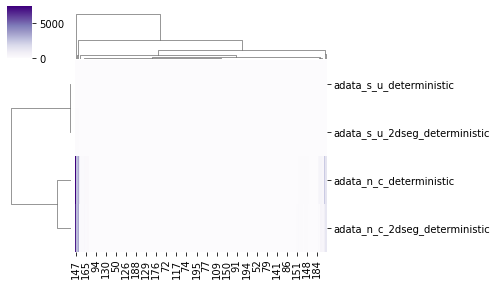

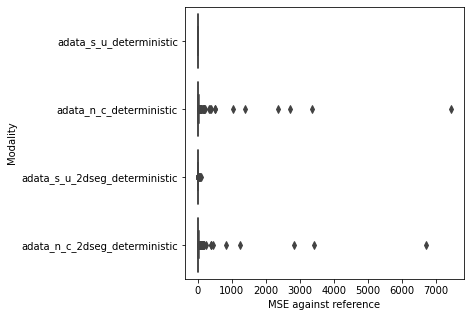

In [23]:
# velo mse against reference 
import matplotlib.pyplot as plt
sns.clustermap(velocity_mse_by_gene.fillna(0),figsize=(7,4),cmap='Purples')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_mse_by_gene.stack().reset_index(),y='level_0',x=0,palette='Purples')
plt.xlabel('MSE against reference')
plt.ylabel('Modality')


In [24]:
# plotting velocity signs
sns.violinplot(data=sign_accuracies,y='Model',x='Accuracy',palette='viridis')

NameError: name 'sign_accuracies' is not defined